In [1]:
from glob import glob
import cv2
import numpy as np
import itertools as it
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon, Wedge
import tifffile as tf

from scipy import ndimage, signal, spatial
from skimage import morphology

import os
import pandas as pd

from importlib import reload

import sklearn.linear_model as linear

In [2]:
boundary = ndimage.generate_binary_structure(2,2).astype(int) - 2
boundary[1,1] = -(np.sum(boundary) + 1)
unique = np.array([40, 120, 160, 200, 240], dtype=np.uint8)

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

rsrc = '../raw/'
src = '../proc/'
dst = '../proc/plots/'
time = '4pm'
rep = 7
pidx = 2

asrc = src + 'anchory/' + time + '_rep{}/'.format(rep)
psrc = src + 'prelim/' + time + '_rep{}/plant_{:02d}/'.format(rep,pidx)

filenames = glob(psrc + '*.tif')

nums = np.zeros(len(filenames), dtype=int) - 1
for i in range(len(nums)):
    num = os.path.splitext(os.path.split(filenames[i])[1])[0].split('_')[-1]
    num = int(num)
    nums[i] = num
        
anums = np.argsort(nums)

In [3]:
metafile = '{}{}_rep{}_plant_{:02d}.csv'.format(asrc, time, rep, pidx)
meta = pd.read_csv(metafile, header=None)
meta.index = nums[anums]
print(meta.shape)
meta.head()

(902, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,2752,4896,945,2081,0,200,0,945,1357,2895,400,944,403,757,724,185.921125,0.006282
2,2752,4896,933,2069,0,200,0,933,1341,2881,392,932,404,758,728,180.337551,0.010735
3,2752,4896,943,2061,0,200,0,943,1346,2877,395,942,390,747,715,181.982886,0.009714
4,2752,4896,929,2064,0,200,0,929,1346,2874,381,928,399,747,718,179.264705,0.010184
5,2752,4896,929,2065,0,200,0,929,1333,2875,379,928,422,760,732,177.980730,0.010895


In [4]:
lenraw = meta.iloc[0,0]
tape = meta.iloc[:,2].values
peak = meta.iloc[:,3].values
buffx = meta.iloc[:,4].values
buffy = meta.iloc[:,5].values

plant = meta.iloc[:, 6:10].values.astype(int)
pss = [ np.s_[plant[i,0]:plant[i,1], plant[i,2]:plant[i,3]] for i in range(len(plant)) ]

ceros = meta.iloc[:, 10:14].values.astype(int)
css = [ np.s_[ceros[i, 0]:ceros[i,1], ceros[i,2]:ceros[i,3]] for i in range(len(ceros)) ]
coef = meta.iloc[:,15:].values

rawx = ceros[:, 2] + plant[:, 2] - peak + buffy
rawy = ceros[:, 0] + plant[:, 0] + buffx

xvals = np.arange(lenraw)
b0 = peak + coef[:, 0] - buffy
lines = b0.reshape(-1,1) + np.outer(coef[:,1], xvals)

line = [ lines[i][pss[i][0]] - plant[i,2] for i in range(len(pss)) ]
ll = [ line[i][np.arange(ceros[i,0], ceros[i,1])] - ceros[i,2] for i in range(len(ceros))]
xx = [ np.arange(ceros[i,1] - ceros[i,0]) for i in range(len(ceros)) ]

v0 = np.column_stack((coef[:,1], np.ones(len(coef))))
v = v0/(np.linalg.norm(v0, axis=1)).reshape(-1,1)
n = np.column_stack((-v[:,1], v[:,0]))
p = np.column_stack(([ll[i][0] for i in range(len(ll))], np.zeros(len(ll))))
b = np.sum(p*n, axis=1)

stick = [ np.s_[buffx[i]:tape[i]+buffx[i], peak[i]-buffy[i]:peak[i]+buffy[i]] for i in range(len(tape)) ]

# Specify the timestamp

In [28]:
idx = 447
print(filenames[anums[idx]])
img = tf.imread(filenames[anums[idx]])
scoords = np.asarray(np.nonzero(img > 160))
skewer = (img == 40) | (img == 160) | (img == 240)
contour = ndimage.grey_erosion(skewer, size=(1,21), mode='constant', cval=255).astype(bool)
img = img*contour
#contour = ndimage.convolve(skewer, boundary, mode='constant')
print(img.shape, img.max())

../proc/prelim/4pm_rep7/plant_02/4pm_rep07_0448.tif
(360, 127) 240


In [29]:
if img.max() > 160:
    cross = np.asarray(np.nonzero(img > 180))
    dist = np.abs(cross[1]*n[idx, 0] + cross[0]*n[idx, 1] - b[idx])
    print('Min dist: {:.2f}\nMax dist: {:.2f}'.format(np.min(dist),np.max(dist)))
    mask = dist < 30
    print(np.sum(mask), np.sum(mask) > 5)

Min dist: 0.05
Max dist: 22.34
91 True


In [30]:
num = 0
if img.max() > 160:
    skel = np.zeros(img.shape, dtype=bool)
    skel[cross[0, mask], cross[1, mask]] = True
    labels,num = ndimage.label(skel, structure=ndimage.generate_binary_structure(2,2))
    
    if num > 0:
        hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
        where = np.nonzero((hist/np.sum(hist) > 0.1))[0]
        
        print(num,'components\t', len(where), 'preserved')
        print(hist, np.round(hist/np.sum(hist), 2))
        print('where:\t', where)
        
        if len(where) > 1:
            merged = dict()
            coords = dict()
            for i in range(len(where)):
                coords[where[i]] = np.asarray(np.nonzero(labels == where[i] + 1))
                merged[where[i]] = []
        
            combs = list(it.combinations(where, 2))
            for i in range(len(combs)):
                dxy = np.min(spatial.distance.cdist(coords[combs[i][0]].T, coords[combs[i][1]].T, metric='euclidean'))
                print(combs[i], dxy, sep='\t')
                
                if dxy < 20:
                    merged[combs[i][1]].append(combs[i][0])
            
            print('merge dict:\t', merged)
            
            for j,i in enumerate(where):
                k = i  
                while len(merged[k]) > 0:
                    k = min(merged[k])
                print(i, '-->', k, sep='\t')
                labels[labels == i+1] = k+1
                where[j] = k
            
            where = np.unique(where)
            print('where:\t', where)

1 components	 1 preserved
[91] [1.]
where:	 [0]


In [31]:
if (img.max() > 160) and (num > 0):
    coms = np.asarray(ndimage.center_of_mass(skel, labels, where+1))
    coms = coms[(tape[idx] - (coms[:,0] + rawy[idx]))/tape[idx] > 0.1]
    print(len(coms))
    dmask = []
    dcom = []
    
    for i in range(len(coms)):
        com = coms[i]
        dd = np.sqrt(np.sum((cross - com.reshape(-1,1))**2, axis=0))
        dmask.append(dd < 20)
        foo = dd[dmask[i]]
        dcom.append(np.max(foo) + 1 - foo)
else:
    coms = []

1


In [32]:
coefs = np.zeros((len(coms), 2))
angle = np.zeros(len(coms))

for i in range(len(coms)):
    X = cross[1, dmask[i]].reshape(-1,1)
    print(X.shape[1] + 1)
    reg = linear.RANSACRegressor(random_state=4, min_samples=4).fit(X, cross[0,dmask[i]], sample_weight = dcom[i])
    coef1 = np.diff(reg.predict([[0],[1]]))[0]
    coef0 = reg.predict([[0]])[0]
    
    w0 = np.array([1, coef1])
    w = w0/np.linalg.norm(w0)
    
    coefs[i] = [coef0, coef1]
    angle[i] = -np.sign(coef1)*np.arccos(np.abs(np.sum(w*n[idx])))
    
print(np.rad2deg(angle))

2
[49.98358643]


In [33]:
img1 = tf.imread(filenames[anums[idx]])//40
img1[img1 > 2] = 0
scalebar = len(img1) - np.asarray([20, 20 + 28*2])
#img1[img1 > 1] = 2

#plt.imshow(img1)

In [34]:
C = np.array([np.array([137, 685, 400, 666]),
              np.array([329, 733, 528, 742]),
              np.array([419, 976, 603, 818]),
              np.array([ 342,  945,  710, 1009]),
              np.array([474, 962, 735, 857])])
w = (C[:,3] - C[:,2])
h = (C[:,1] - C[:,0])
W = int(np.max(w/h)*h[pidx]) - w[pidx]
ww = W//2
ww

40

../proc/plots/4pm_rep7_plant2_v08_0448


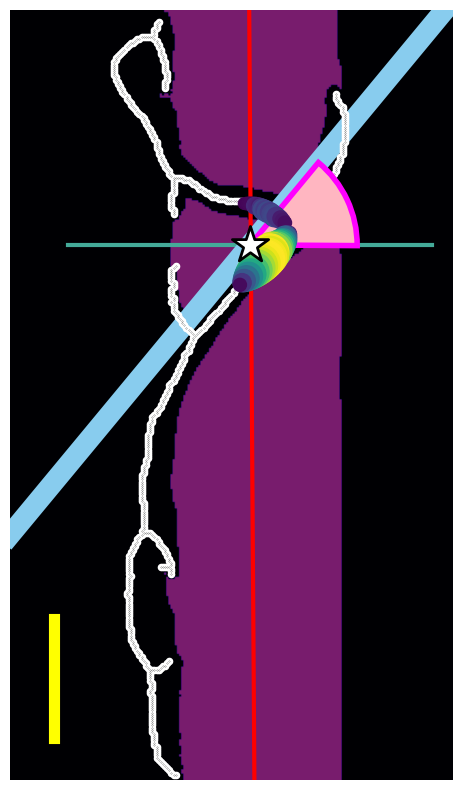

In [35]:
colors = [None, '#117733', '#aa4499', '#332288', '#ddcc77', '#88ccee', '#44aa99']

fig, ax = plt.subplots(1,1,figsize=(6,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(np.pad(img1, ((0,0), (ww,ww))), cmap='inferno', vmin=0, vmax=3, zorder = 1, origin='upper');

for i in range(len(coms)):
    i = -i - 1 
    xy1 = (coms[i,1]+ww, coms[i,0])
    xy2 = np.array([xy1[0]-85, xy1[0]+85])
    grad = (dcom[i]/np.max(dcom[i]))

    #ax[0].axline(xy1, slope = ll[idx][1]-ll[idx][0], c='yellow', alpha=1, lw=2, ls='-.', zorder=3)
    ax[0].plot([xy1[0]-85, xy1[0]+85], [xy1[1], xy1[1]], c=colors[6], alpha=1, lw=3, ls='-', zorder=3)
    ax[0].axline(xy1, slope = coefs[i,1], c=colors[6+i], alpha=1, lw=15, zorder=4)
    
    ax[0].scatter(cross[1, dmask[i]]+ww, cross[0, dmask[i]], 
                  c=dcom[i], alpha=1, marker='o', cmap='viridis', s=750*grad, zorder=10)
    
    ax[0].scatter(*xy1, c='w', s=750, marker='*', zorder=15, edgecolor='k', linewidths=2)
    wedges = Wedge(xy1, 50, np.rad2deg(np.arctan(coefs[i,1])), 
                   np.rad2deg(np.arctan(ll[idx][1]-ll[idx][0])),
                   #width = 5,
                   facecolor='lightpink', edgecolor='fuchsia', lw=4, alpha=1, zorder=9) 
    ax[0].add_patch(wedges)

ax[0].plot([20,20], scalebar, c='yellow', lw=8, zorder=11)
ax[0].scatter(scoords[1]+ww, scoords[0], c='w', marker='o', zorder=6, s=20, alpha=1)
ax[0].scatter(scoords[1]+ww, scoords[0], c='k', marker='.', zorder=6, s=0.1, alpha=1)
ax[0].plot(ll[idx]+ww,xx[idx], color='red', lw=3, zorder=2);
ax[0].axis('off')
ax[0].margins(0)

fig.tight_layout()

filename = '{}{}_rep{}_plant{}_v08_{:04d}'.format(dst,time,rep,pidx,nums[anums[idx]])
print(filename)
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

In [20]:
img0 = tf.imread(filenames[anums[idx]])
img1 = tf.imread(filenames[anums[idx]])//40
img1[img1 > 1] = 2
img1[img0 > 160] += 2

../proc/plots/4pm_rep7_plant2_v06_0330


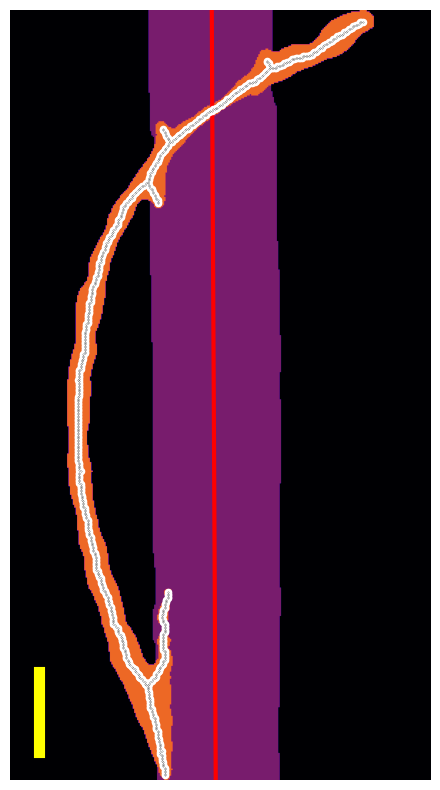

In [21]:
colors = [None, '#117733', '#aa4499', '#332288', '#ddcc77', '#88ccee', '#44aa99']

fig, ax = plt.subplots(1,1,figsize=(6,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(np.pad(img1, ((0,0), (ww,ww))), cmap='inferno', vmin=0, vmax = 3, zorder = 1, origin='upper');

ax[0].plot([20,20], scalebar, c='yellow', lw=8, zorder=11)
ax[0].scatter(scoords[1]+ww, scoords[0], c='w', marker='o', zorder=6, s=20, alpha=1)
ax[0].scatter(scoords[1]+ww, scoords[0], c='k', marker='.', zorder=6, s=0.1, alpha=1)
ax[0].plot(ll[idx]+ww,xx[idx], color='red', lw=3, zorder=2);
ax[0].axis('off')
ax[0].margins(0)

fig.tight_layout()

filename = '{}{}_rep{}_plant{}_v06_{:04d}'.format(dst,time,rep,pidx,nums[anums[idx]])
print(filename)
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')